# Quantum Counting

To understand this algorithm, it is important that you first understand both Grover’s algorithm and the quantum phase estimation algorithm. Whereas Grover’s algorithm attempts to find a solution to the Oracle, the quantum counting algorithm tells us how many of these solutions there are. This algorithm is interesting as it combines both quantum search and quantum phase estimation.

## Contents

1. [Overview](#overview)    
    1.1 [Intuition](#intuition)    
    1.2 [A Closer Look](#closer_look)    
2. [The Code](#code)    
    2.1 [Initialising our Code](#init_code)    
    2.2 [The Controlled-Grover Iteration](#cont_grover)    
    2.3 [The Inverse QFT](#inv_qft)    
    2.4 [Putting it Together](#putting_together)    
3. [Simulating](#simulating)    
4. [Finding the Number of Solutions](#finding_m)
5. [Exercises](#exercises)
6. [References](#references)

## 1. Overview <a id='overview'></a>

### 1.1 Intuition <a id='intuition'></a>

In quantum counting, we simply use the quantum phase estimation algorithm to find an eigenvalue of a Grover search iteration. You will remember that an iteration of Grover’s algorithm, $G$, rotates the state vector by $\theta$ in the $|\omega\rangle$, $|s’\rangle$ basis:
![image1](images/quantum_counting1.svg)


The percentage number of solutions in our search space affects the difference between $|s\rangle$ and $|s’\rangle$. For example, if there are not many solutions, $|s\rangle$ will be very close to $|s’\rangle$ and $\theta$ will be very small. It turns out that the eigenvalues of the Grover iterator are $e^{\pm i\theta}$, and we can extract this using quantum phase estimation (QPE) to estimate the number of solutions ($M$).

### 1.2 A Closer Look <a id='closer_look'></a>

In the $|\omega\rangle$,$|s’\rangle$ basis we can write the Grover iterator as the matrix:

$$
G =
\begin{pmatrix}
\cos{\theta} && -\sin{\theta}\\
\sin{\theta} && \cos{\theta}
\end{pmatrix}
$$

The matrix $G$ has eigenvectors:

$$
\begin{pmatrix}
-i\\
1
\end{pmatrix}
,
\begin{pmatrix}
i\\
1
\end{pmatrix}
$$

With the aforementioned eigenvalues $e^{\pm i\theta}$. Fortunately, we do not need to prepare our register in either of these states, the state $|s\rangle$ is in the space spanned by $|\omega\rangle$, $|s’\rangle$, and thus is a superposition of the two vectors.
$$
|s\rangle = \alpha |\omega\rangle + \beta|s'\rangle
$$

As a result, the output of the QPE algorithm will be a superposition of the two phases, and when we measure the register we will obtain one of these two values! We can then use some simple maths to get our estimate of $M$.

![image2](images/quantum_counting2.svg)


## 2. The Code <a id='code'></a>

### 2.1 Initialising our Code <a id='init_code'></a>

First, let’s import everything we’re going to need:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.visualization import plot_histogram

Next let’s initialise our registers and circuit objects:

In [2]:
qreg = QuantumRegister(8, 'q')   # First 4 are for counting, last 4 for 'searching'
t = 4   # no. of counting qubits
n = 4   # no. of searching qubits
creg = ClassicalRegister(4, 'c')
circ = QuantumCircuit(qreg, creg)

In this guide we choose to ‘count’ on the first 4 qubits (we call the number of counting qubits $t$, so $t = 4$), and to 'search' through the last 4 qubits ($n = 4$). Since we only care about the measurement of the counting qubits, we have initialised 4 classical bits to measure to.
With that done, we can start creating the building blocks of our circuit.

### 2.2 The Controlled-Grover Iteration <a id='cont_grover'></a>

We have already covered Grover iterations in the Grover’s algorithm section. Here is an example with an Oracle we know has 5 solutions ($M = 5$) of 16 states ($N = 2^n = 16$), combined with a diffusion operator:

In [3]:
from qiskit.aqua.circuits.gates.multi_control_toffoli_gate import _cccx

def example_grover_iteration():
    """Small circuit with 5/16 solutions"""
    # Do circuit
    q = QuantumRegister(4, 'q')
    circ = QuantumCircuit(q)
    # Oracle
    circ.h(3)
    _cccx(circ,q)
    circ.x(0)
    _cccx(circ,q)
    circ.x(0)
    circ.x(1)
    _cccx(circ,q)
    circ.x(1)
    circ.x(2)
    _cccx(circ,q)
    circ.x(2)
    circ.x(1)
    circ.x(2)
    _cccx(circ,q)
    circ.x(2)
    circ.x(1)
    circ.h(3)
    # Diffusion Operator
    circ.z(3)
    for qubit in q[:3]:
        circ.h(qubit)
        circ.x(qubit)
    _cccx(circ,q)
    for qubit in q[:3]:
        circ.x(qubit)
        circ.h(qubit)
    circ.z(3)
    return circ

Notice the python function takes no input and returns a `QuantumCircuit` object with 4 qubits. In the past the functions you created might have modified an existing circuit, but a function like this allows us to turn the `QuantmCircuit` object into a single gate we can then control.

We can use `.to_gate()` and `.control()` to create a controlled gate from a circuit. We will call our Grover iterator `grit` and the controlled Grover iterator `cgrit`:

In [4]:
# Create controlled-Grover
grit = example_grover_iteration().to_gate()
cgrit = grit.control()

### 2.3 The Inverse QFT <a id='inv_qft'></a>
We now need to create an inverse QFT. This code implements the QFT on n qubits:

In [5]:
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

Again, note we have chosen to return another `QuantumCircuit` object, this is so we can easily invert the gate. We create the gate with t = 4 qubits as this is the number of counting qubits we have chosen in this guide:

In [6]:
qft_dagger = qft(QuantumCircuit(4),4).to_gate().inverse()

### 2.4 Putting it Together <a id='putting_together'></a>

We now have everything we need to complete our circuit! Let’s put it together.

First we need to put all qubits in the $|+\rangle$ state:

In [7]:
# Initialise all qubits to |+>
for qubit in qreg:
    circ.h(qubit)

Easy enough! Next we need to do controlled Grover iterations for each qubit in the counting register, doubling the number of iterations each time. Note that we must `.append()` our custom gate to `circ`, and that the order of the qubits is opposite to that found in most textbooks:

In [8]:
# Begin controlled Grover iterations
iterations = 1
for qubit in qreg[:4]:
    for i in range(iterations):
        circ.append(cgrit, qargs=[qubit] + qreg[4:])
    iterations *= 2

Next we apply our inverse QFT to the counting qubits:

In [9]:
# Do inverse QFT on counting qubits
circ.append(qft_dagger, qargs=qreg[:4])

And finally we measure the counting qubits and store the results in the classical register:


In [10]:
# Measure Qubits
circ.measure(qreg[:4],creg)

Let's check our circuit looks correct:

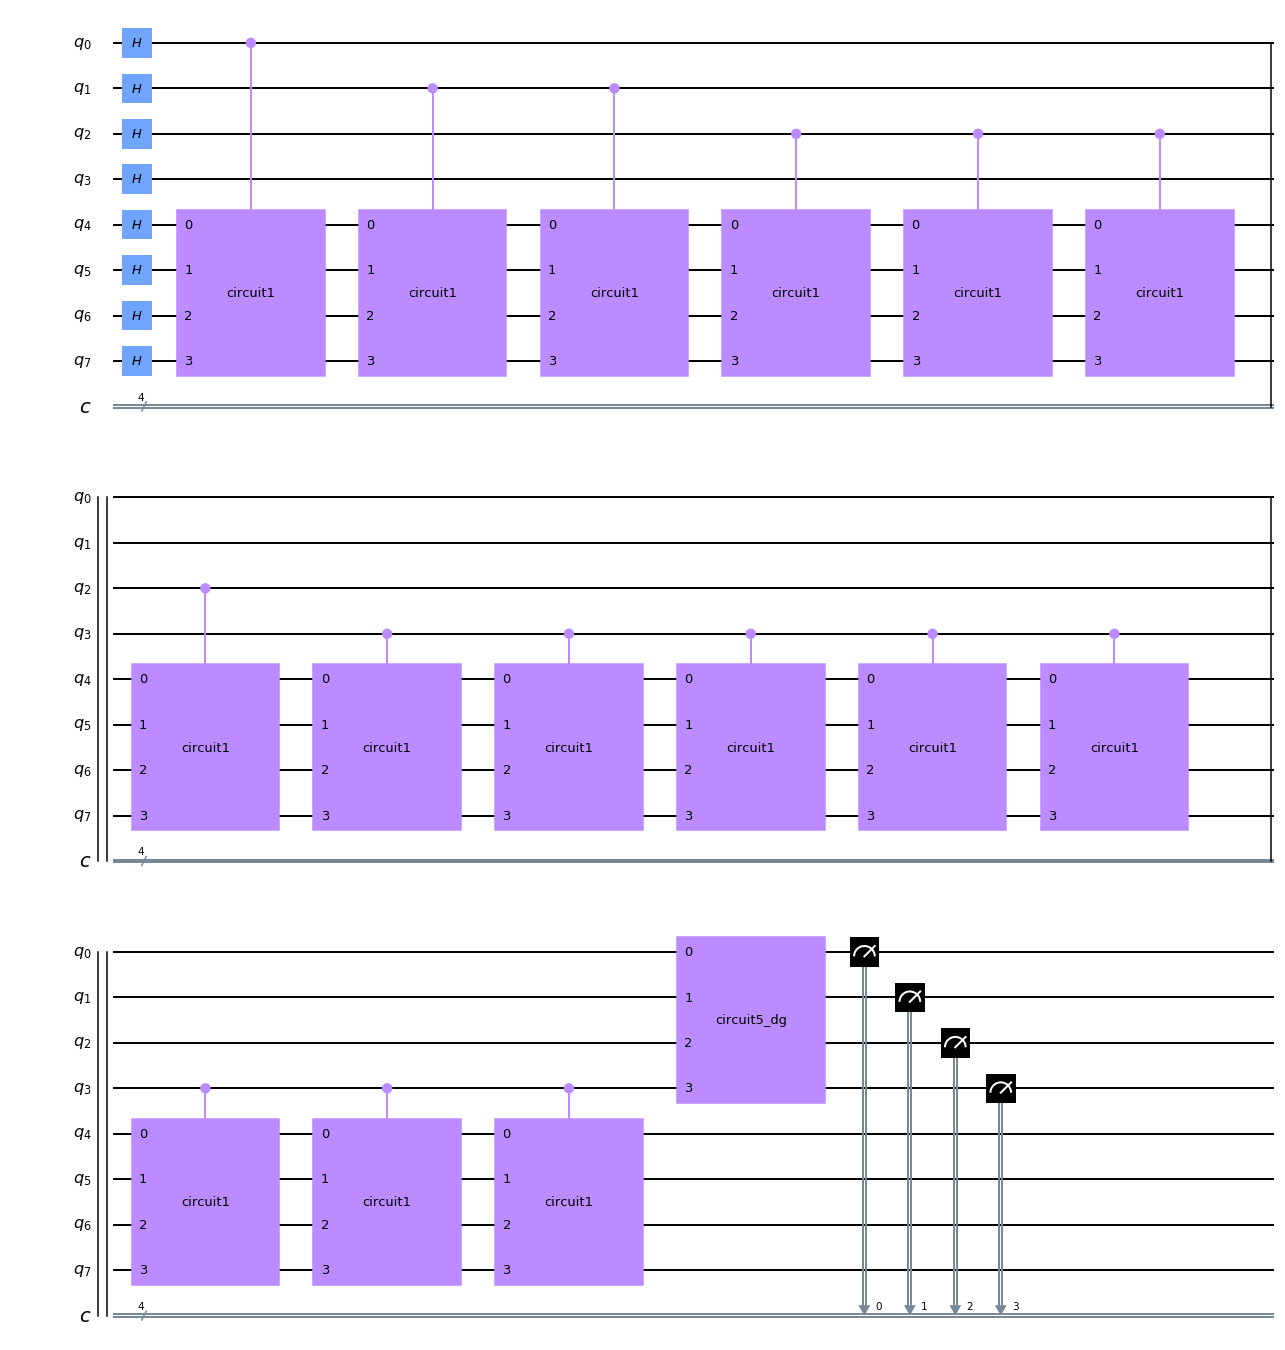

In [11]:
circ.draw(output='mpl')

Great! Now let’s see some results.

## 3. Simulating <a id='simulating'></a>

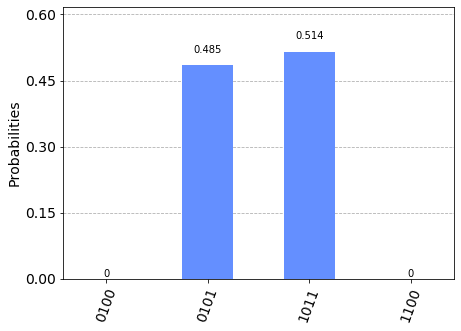

In [12]:
# Execute and see results
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=2048 )
hist = job.result().get_counts()
plot_histogram(hist)

We can see two values stand out, having a much higher probability of measurement than the rest. These two values correspond to $e^{i\theta}$ and $e^{-i\theta}$, but we can’t see the number of solutions yet. We need to little more processing to get this information, so first let us get our output into something we can work with (an `int`).

We will get the string of the most probable result from our output data:

In [13]:
measured_str = max(hist, key=hist.get)

Let us now store this as an integer:

In [14]:
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 11


## 4. Finding the Number of Solutions (M) <a id='finding_m'></a>

We will create a function, `calculate_M()` that takes as input the decimal integer output of our register, the number of counting qubits ($t$) and the number of searching qubits ($n$).

First we want to get $\theta$ from `measured_int`. You will remember that QPE gives us a measured $\text{value} = 2^n \phi$ from the eigenvalue $e^{2\pi i\phi}$, so to get $\theta$ we need to do:

$$
\theta = \text{value}\times\frac{2\pi}{2^t}
$$

Or, in code:

In [15]:
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

Theta = 4.31969


You may remember that we can get the angle $\theta/2$ can from the inner product of $|s\rangle$ and $|s’\rangle$:

![image3](images/quantum_counting3.svg)

$$
\langle s'|s\rangle = \cos{\tfrac{\theta}{2}}
$$

And that the inner product of these vectors is:

$$
\langle s'|s\rangle = \sqrt{\frac{N-M}{N}}
$$

We can combine these equations, then use some trigonometry and algebra to show:

$$
N\sin^2{\frac{\theta}{2}} = M
$$

And in code:

In [16]:
N = 2**n
M = N * (math.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

No. of Solutions = 4.9


And we can see we have (approximately) the correct answer! This is not *that* precise as we are only using 4 qubits. You might think that 4 qubits would be enough to give us an exact answer, but remember this space is split between two eigenvalues ($e^{\pm i\theta}$) and we lose some precision to the squared sine function. We can approximately calculate the error using:

In [17]:
m = t - 1 # Upper bound: Will be less than this 
err = (math.sqrt(2*M*N) + N/(2**(m-1)))*(2**(-m))
print("Error < %.2f" % err)

Error < 2.85


Explaining the error calculation is outside the scope of this article, but an explanation can be found in [1].

Finally, here is the finished function `calculate_M()`:

In [18]:
def calculate_M(measured_int, t, n):
    """For Processing Output of Quantum Counting"""
    # Calculate Theta
    theta = (measured_int/(2**t))*math.pi*2
    print("Theta = %.5f" % theta)
    # Calculate No. of Solutions
    N = 2**n
    M = N * (math.sin(theta/2)**2)
    print("No. of Solutions = %.1f" % (N-M))
    # Calculate Upper Error Bound
    m = t - 1 #Will be less than this (out of scope) 
    err = (math.sqrt(2*M*N) + N/(2**(m-1)))*(2**(-m))
    print("Error < %.2f" % err)

## 5. Exercises <a id='exercises'></a>

1.	Can you create an oracle with a different number of solutions? How does the accuracy of the quantum counting algorithm change?
2.	Can you adapt the circuit to use more or less counting qubits to get a different precision in your result?


## 6. References <a id='references'></a>

[1] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition (10th ed.). Cambridge University Press, New York, NY, USA. 

In [19]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.12.0',
 'qiskit-aer': '0.4.1',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.6.0',
 'qiskit-aqua': '0.6.5',
 'qiskit': '0.17.0'}